In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as signal
import os


fn = os.path.join('..', 'data', 'BP_data.pkl')
df = pd.read_pickle(fn)

print(df)
print(df.columns)

    SubjectID Condition  Age Gender  Height  Weight  SystolicP  DiastolicP  \
0    c010510d        BN   63      M   170.0    66.1      161.0        82.5   
1    c010510d        BN   63      M   170.0    66.1      162.2        82.8   
2    c010510d        AN   63      M   170.0    66.1      155.2        80.3   
3    c010510d        AN   63      M   170.0    66.1      157.3        79.3   
4    c010610d        BN   49      M   175.2    82.4      129.5        72.6   
..        ...       ...  ...    ...     ...     ...        ...         ...   
189  c121609d        BN   84      M   163.0    50.0      140.1        65.4   
190  c121609d        AN   84      M   163.0    50.0      133.8        64.2   
191  c122309d        BN   65      F   154.2    62.6      139.6        69.9   
192  c122309d        BN   65      F   154.2    62.6      140.2        69.3   
193  c122309d        AN   65      F   154.2    62.6      139.7        72.7   

     MeanP                                              CuffP  

In [14]:

def make_features(d):
    
    features = {}


    def normalize(x):
        xn = (x-np.min(x))/(np.max(x)-np.min(x))
        return xn

    d['Amplitude'] = normalize(d['Amplitude'])
    d['Area'] = normalize(d['Area'])

    amplitude_data_smooth = signal.savgol_filter(d['Amplitude'], 50, 3, mode = 'nearest')
    area_data_smooth = signal.savgol_filter(d['Area'], 50, 3, mode = 'nearest')

    amplitude_data_smooth = normalize(amplitude_data_smooth)
    area_data_smooth = normalize(area_data_smooth)

    I_area_max_slope = np.argmax(np.diff(area_data_smooth))
    I_amplitude_max_slope = np.argmax(np.diff(amplitude_data_smooth))

    I_area_min_slope = np.argmin(np.diff(area_data_smooth))
    I_amplitude_min_slope = np.argmin(np.diff(amplitude_data_smooth))

    I_area_max = np.argmax(area_data_smooth)
    I_amplitude_max = np.argmax(amplitude_data_smooth)


    crit_points = [.8, .7, .5]

    for cp in crit_points:

        flag = np.where(area_data_smooth>=cp)[0][0]
        c = d['CuffP'][flag]
        features[f'area_falling_{cp}'] = c

        flag = np.where(area_data_smooth<=cp)[0][-1]
        c = d['CuffP'][flag]
        features[f'area_rising_{cp}'] = c

        flag = np.where(amplitude_data_smooth>=cp)[0][0]
        c = d['CuffP'][flag]
        features[f'amplitude_falling_{cp}'] = c

        flag = np.where(amplitude_data_smooth<=cp)[0][-1]
        c = d['CuffP'][flag]
        features[f'amplitude_rising_{cp}'] = c


    CuffP_area_max = d['CuffP'][I_area_max]
    CuffP_amplitude_max = d['CuffP'][I_amplitude_max]

    CuffP_area_slope_max = d['CuffP'][I_area_max_slope]
    CuffP_amplitude_slope_max = d['CuffP'][I_amplitude_max_slope]

    CuffP_area_slope_min = d['CuffP'][I_area_min_slope]
    CuffP_amplitude_slope_min = d['CuffP'][I_amplitude_min_slope]

    features['CuffP_area_max'] = CuffP_area_max
    features['CuffP_amplitude_max'] = CuffP_amplitude_max
    features['CuffP_area_slope_max'] = CuffP_area_slope_max
    features['CuffP_amplitude_slope_max'] = CuffP_amplitude_slope_max
    features['CuffP_area_slope_min'] = CuffP_area_slope_min
    features['CuffP_amplitude_slope_min'] = CuffP_amplitude_slope_min


    return features

results = []
for idx in df.index[:]:
    d = df.loc[idx, :].copy()
    features = make_features(d)
    print(features)
    results.append(features)


{'area_falling_0.8': 84.53532, 'area_rising_0.8': 205.89714, 'amplitude_falling_0.8': 90.99073, 'amplitude_rising_0.8': 205.89714, 'area_falling_0.7': 78.0799, 'area_rising_0.7': 205.89714, 'amplitude_falling_0.7': 84.53532, 'amplitude_rising_0.7': 205.89714, 'area_falling_0.5': 78.0799, 'area_rising_0.5': 205.89714, 'amplitude_falling_0.5': 78.0799, 'amplitude_rising_0.5': 205.89714, 'CuffP_area_max': 103.901566, 'CuffP_amplitude_max': 110.35699, 'CuffP_area_slope_max': 80.66207, 'CuffP_amplitude_slope_max': 87.117485, 'CuffP_area_slope_min': 123.267815, 'CuffP_amplitude_slope_min': 146.50731}
{'area_falling_0.8': 87.884766, 'area_rising_0.8': 187.09329, 'amplitude_falling_0.8': 92.84519, 'amplitude_rising_0.8': 187.09329, 'area_falling_0.7': 84.16445, 'area_rising_0.7': 187.09329, 'amplitude_falling_0.7': 87.884766, 'amplitude_rising_0.7': 187.09329, 'area_falling_0.5': 77.96391, 'area_rising_0.5': 187.09329, 'amplitude_falling_0.5': 80.44413, 'amplitude_rising_0.5': 187.09329, 'Cuff

In [15]:
df_features = pd.DataFrame(results)

df2 = pd.concat([df.loc[:,['MeanP', 'DiastolicP', 'SystolicP', 'Age', 'Gender',  'Height',  'Weight']], df_features], axis = 1)

print(df2)

df2.to_csv('features.csv')

print(df2.columns)

     MeanP  DiastolicP  SystolicP  Age Gender  Height  Weight  \
0    113.5        82.5      161.0   63      M   170.0    66.1   
1    113.4        82.8      162.2   63      M   170.0    66.1   
2    106.8        80.3      155.2   63      M   170.0    66.1   
3    106.9        79.3      157.3   63      M   170.0    66.1   
4     96.7        72.6      129.5   49      M   175.2    82.4   
..     ...         ...        ...  ...    ...     ...     ...   
189   91.7        65.4      140.1   84      M   163.0    50.0   
190   87.0        64.2      133.8   84      M   163.0    50.0   
191  100.1        69.9      139.6   65      F   154.2    62.6   
192  100.2        69.3      140.2   65      F   154.2    62.6   
193   96.2        72.7      139.7   65      F   154.2    62.6   

     area_falling_0.8  area_rising_0.8  amplitude_falling_0.8  ...  \
0           84.535316       205.897141              90.990730  ...   
1           87.884766       187.093292              92.845192  ...   
2        

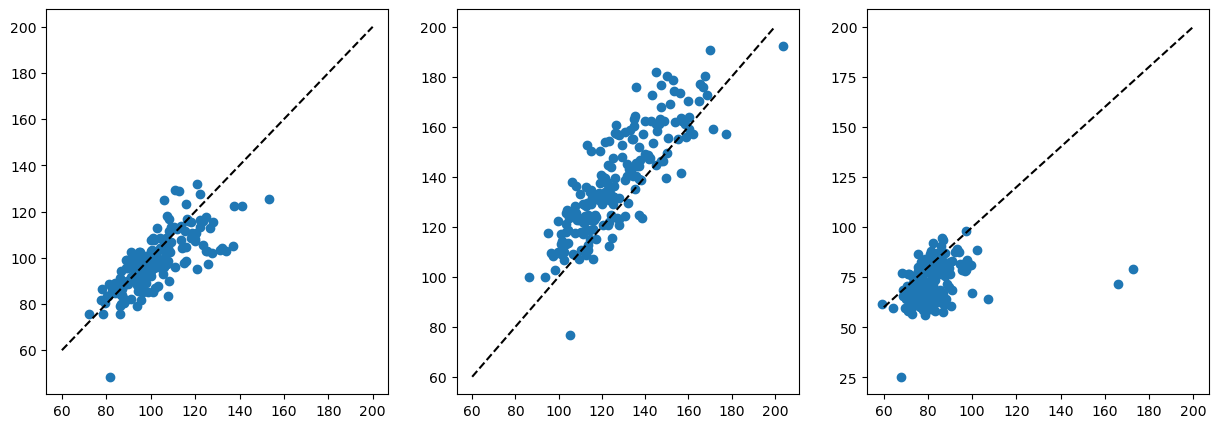

In [16]:
fig,ax = plt.subplots(1, 3)

lims = [60, 200]

ax[0].scatter(df2['CuffP_amplitude_max'], df2['MeanP'], label = 'mean P')
ax[0].plot(lims, lims, 'k--')

ax[1].scatter(df2['CuffP_amplitude_slope_min'], df2['SystolicP'], label = 'S P')
ax[1].plot(lims, lims, 'k--')

ax[2].scatter(df2['CuffP_amplitude_slope_max'], df2['DiastolicP'], label = 'DP')
ax[2].plot(lims, lims, 'k--')

fig.set_size_inches(15, 5)
